In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [170]:
# dynamics definition
numPlayers = 4;
T = 10;
A = np.eye(2);
B = np.zeros((2, 1, numPlayers))
B[:,:,0] = np.array([[1], [0]]);
B[:,:,1] = np.array([[1], [-1]])/np.sqrt(2);
B[:,:,2] = np.array([[1], [1]])/np.sqrt(2);
B[:,:,3] = np.array([[0], [-1]]);
G = np.zeros((2*T, T*1, numPlayers)); # 2 is the row dim of B, 1 is the column dim of B
H = np.zeros((T*2, 2));
for p in range(numPlayers):
    for col in range(T):
        Abar = np.eye(2); row=col+1;
        while row < T:
            G[row*2: (row+1)*2, col, p] = np.squeeze(Abar.dot(B[:,:,p]));
            if p == 0:
                H[col*2:(col+1)*2,:] = 1.0*Abar;
            Abar  = Abar.dot(A);
            row += 1;
Rscaler = 0.1;
Q = np.eye(2);
R = Rscaler*np.eye(1);
print (G[:,:,3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1.  0.]]


In [162]:
# derive the step sizes
J = np.zeros((T*numPlayers,T*numPlayers));
diagQ = np.eye(2*T); diagR = Rscaler*np.eye(T);
for i in range(T):
    diagQ[i*2: 2*(i+1), 2*i: 2*(i+1)] = Q;
    diagR[i: (i+1), i: (i+1)] = R;
    
for i in range(numPlayers):
    for j in range(numPlayers):
        J[T*i:T*(i+1), T*j:T*(j+1)]  = G[:,:,i].T.dot(diagQ).dot(G[:,:,j]);
        if i == j:
            J[T*i:T*(i+1), T*i:T*(i+1)] += diagR;
S = 0.5*(J + J.T);  
eigS, eigVecS = np.linalg.eig(S.T.dot(S));
# print (eigS);
alpha = np.min(eigS); 
eigJ, eigVecJ = np.linalg.eig(J.T.dot(J));
beta = np.max(eigJ);
gammai = np.sqrt(alpha)/beta;
# gammai= alpha/beta;

print (gammai)
dim, dim2 = J.shape;
barA = np.eye(dim) - gammai*J; 
w, v = np.linalg.eig(barA);
print (w)            


(1.8550768319882614e-05+0j)
[0.99863799+0.j 0.99863799+0.j 0.99984423+0.j 0.99984423+0.j
 0.99996714+0.j 0.99994066+0.j 0.99994066+0.j 0.99996714+0.j
 0.99997792+0.j 0.99997792+0.j 0.99998325+0.j 0.99998325+0.j
 0.99998778+0.j 0.99998615+0.j 0.99998615+0.j 0.99998778+0.j
 0.99998861+0.j 0.99998861+0.j 0.99999814+0.j 0.99999814+0.j
 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j
 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j
 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j
 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j
 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j 0.99999814+0.j]


In [112]:
print(J.shape)

(200, 200)


In [163]:
K = 50; # number of times to iterate
# run gradient dynamics
x0 = np.random.rand((2)) + np.array([-0.5, -0.5]);
ut = np.zeros((numPlayers*T,K));
Jt = np.zeros((K, numPlayers));
ut[:,0] = np.random.rand((numPlayers*T));
Hstacked = np.zeros((numPlayers*T, 2));

for p in range(numPlayers):
    Hstacked[p*T:(p+1)*T, :] = G[:, :, p].T.dot(diagQ).dot(H);
     
xt = np.zeros((T*2, K))    
for k in range(K):
    if k> 0:
        ut[:, k] = barA.dot(ut[:,k-1]) - gammai*numPlayers*Hstacked.dot(x0);
    xt[:,k] = H.dot(x0);
    for p in range(numPlayers):
#         print((p+1)*T)
        xt[:,k] += G[:,:,p].dot(ut[p*T:(p+1)*T,k]);
    for p in range(numPlayers):  
#         print(p+1)
        Jt[k,p] = 0.5*xt[:,k].T.dot(diagQ).dot(xt[:,k]) + 0.5*ut[p*T:(p+1)*T, k].T.dot(diagR).dot(ut[p*T:(p+1)*T, k]); 
# drawGame(x0, u0)
# print(np.linspace(0,K,100).shape)

/home/sarahli/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


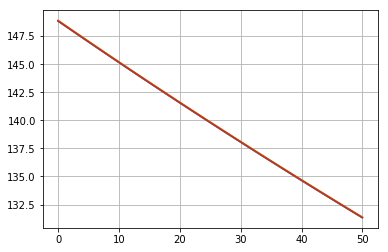

In [164]:
plt.figure()
for p in range(numPlayers):
    plt.plot(np.linspace(0,K,K), Jt[:,p]);
plt.grid()
# plt.yscale('log')
plt.show()

In [165]:
xF = xt[:,K-1];
print (xF);
uF = ut[:,K-1]
print (uF);
# print (A)
# fig, ax = plt.subplots()
# ax.set_xlim((-1, 1));
# ax.set_ylim((-1, 2));


# plt.figure()
# for p in range(numPlayers):
#     plt.plot(np.linspace(0,K,100), Jt[:,p]);
# plt.grid()
# plt.yscale('log')
# plt.show()

[-5.66290752e-03  2.26882125e-01  3.25756495e-01 -5.79089875e-01
  2.01069839e+00 -1.00682904e+00  2.74859792e+00 -1.31597379e+00
  3.28313662e+00 -1.65203832e+00  4.14050190e+00 -2.37221441e+00
  4.65662418e+00 -2.71621861e+00  5.97993585e+00 -2.88346129e+00
  6.95998917e+00 -3.47027186e+00  7.91853515e+00 -3.87702817e+00]
[ 0.05747208  0.57481797  0.28179292  0.04245395  0.15932621  0.1307143
  0.81237813  0.28306204  0.09177716  0.48010766  0.2892302   0.85364412
  0.54619014  0.41316591  0.62332698  0.14710586  0.40750217  0.4944745
  0.32397833  0.89579079  0.09818983  0.71630819  0.09884203  0.28274701
  0.36384933  0.39794333  0.31506697  0.49122001  0.89380934  0.35738576
  0.67088606  0.33062799 -0.00717813  0.24384445  0.53669769  0.52137307
  0.10188112  0.5845093   0.58280556  0.42551309]


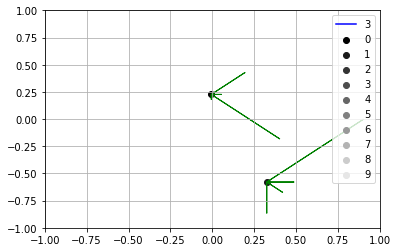

In [166]:
def drawGame(xt, ut):
    plt.figure();
    
    for p in range(numPlayers):
        plt.arrow(x0[0], x0[1],  B[0,0,p]*ut[p], B[1, 0, p]*ut[p], color = 'g');
    plt.scatter(x0[0], x0[1], color = 'b');
    bounds = 0.5*np.array([[-1,-1,1,1], [-1,1,1,-1]]);
    plt.scatter(bounds[0,:], bounds[1,:], color = 'w');
    plt.grid();
    plt.show();
# originX = np.ones(4)*xF[2*i];
# originY = np.ones(4)*xF[2*i+1];
# dx = np.array([B[0,0,0]*ut[numPlayers*i, K-1],
#                B[0,0,1]*ut[numPlayers*i+1, K-1],
#                B[0,0,2]*ut[numPlayers*i+2, K-1],
#                B[0,0,3]*ut[numPlayers*i+3, K-1]]);
# dy = np.array([B[1,0,0]*ut[numPlayers*i, K-1],
#                B[1,0,1]*ut[numPlayers*i+1, K-1],
#                B[1,0,2]*ut[numPlayers*i+2, K-1],
#                B[1,0,3]*ut[numPlayers*i+3, K-1]]);

# print (dx)
fig, ax = plt.subplots();
limits = 1;
ax.set_xlim((-limits, limits));
ax.set_ylim((-limits, limits));
plt.plot(xF[2*i], xF[2*i+1], color = 'b', label = str(i));
#     originX = np.ones(4)*xF[2*i];
for i in range(T):
#     print(i)
    plt.scatter(xF[2*i], xF[2*i+1], color = (1.*i/T,1.*i/T,1.*i/T), label = str(i));
#     originX = np.ones(4)*xF[2*i];
#     originY = np.ones(4)*xF[2*i+1];
    dx = np.array([B[0,0,0]*ut[numPlayers*i, K-1],
                   B[0,0,1]*ut[numPlayers*i+1, K-1],
                   B[0,0,2]*ut[numPlayers*i+2, K-1],
                   B[0,0,3]*ut[numPlayers*i+3, K-1]]);
    dy = np.array([B[1,0,0]*ut[numPlayers*i, K-1],
                   B[1,0,1]*ut[numPlayers*i+1, K-1],
                   B[1,0,2]*ut[numPlayers*i+2, K-1],
                   B[1,0,3]*ut[numPlayers*i+3, K-1]]);
    # plt.arrow(originX, originY,  dx, dy, color = 'g');
    for p in range(numPlayers):
#         print(xF[2*i], xF[2*i+1],  dx[p], dy[p])
        plt.arrow(xF[2*i], xF[2*i+1],  dx[p], dy[p], color = 'g');
plt.grid();
plt.legend()
plt.show()

In [82]:
print( Jt[:,1])

[2152.31715344 2084.51496708 2018.88326928 1955.35248486 1893.85526923
 1834.32643686 1776.70289212 1720.9235622  1666.92933231 1614.6629829
 1564.06912884 1515.0941607  1467.68618774 1421.79498285 1377.37192918
 1334.36996858 1292.74355152 1252.44858884 1213.44240484 1175.68369199
 1139.1324671  1103.75002882 1069.49891654 1036.34287065 1004.246794
  973.17671463  943.09974973  913.98407068  885.79886929  858.51432505
  832.10157347  806.53267546  781.78058763  757.81913358  734.6229761
  712.16759029  690.42923748  669.38494004  649.012457    629.29026039
  610.19751242  591.71404334  573.82032999  556.49747514  539.72718735
  523.49176158  507.77406041  492.5574958   477.8260115   463.56406601]


Traceback (most recent call last):
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/animation.py", line 1772, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-51-c5afcc55fbff>", line 21, in animate
    ax.add_patch(locPatch);
  File "/home/sarahli/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 2032, in add_patch
    self._set_arti

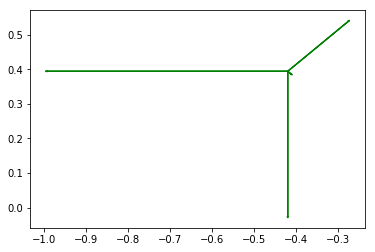

In [51]:
fig = plt.figure()
ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1));
def animate(i):
    ax.clear() 
    originX = np.ones(4)*xF[2*i];
    originY = np.ones(4)*xF[2*i+1];
    dx = np.array([B[0,0,0]*ut[numPlayers*i, K-1],
                   B[0,0,1]*ut[numPlayers*i+1, K-1],
                   B[0,0,2]*ut[numPlayers*i+2, K-1],
                   B[0,0,3]*ut[numPlayers*i+3, K-1]]);
    dy = np.array([B[1,0,0]*ut[numPlayers*i, K-1],
                   B[1,0,1]*ut[numPlayers*i+1, K-1],
                   B[1,0,2]*ut[numPlayers*i+2, K-1],
                   B[1,0,3]*ut[numPlayers*i+3, K-1]]);
    for p in range(numPlayers):
#         print(originX[p], originY[p],  dx[p], dy[p])
        patch = plt.arrow(originX[p], originY[p],  dx[p], dy[p], color = 'g');
#         patch = plt.Arrow(originX, originY, dx, dy)
        ax.add_patch(patch);
    locPatch = plt.plot(xF[2*i], xF[2*i+1], color='b');
    ax.add_patch(locPatch);
    
    return patch, locPatch
anim = animation.FuncAnimation(fig, animate, frames=K, interval = 20, blit=True);
